<a href="https://colab.research.google.com/github/VaibhavShah1512/NN_from_Scratch/blob/main/Capstone_Project_Imperial_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project
## Probabilistic generative models
### Instructions

In this notebook, you will practice working with generative models, using both normalising flow networks and the variational autoencoder algorithm. You will create a synthetic dataset with a normalising flow with randomised parameters. This dataset will then be used to train a variational autoencoder, and you will used the trained model to interpolate between the generated images. You will use concepts from throughout this course, including Distribution objects, probabilistic layers, bijectors, ELBO optimisation and KL divergence regularisers.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports below. For this project you are free to make further imports throughout the notebook as you wish.

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Dense, Flatten, Reshape, Conv2D, Conv2DTranspose,
                                     BatchNormalization, ReLU, LeakyReLU)

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
print('TensorFlow version:', tf.__version__)
print('TensorFlow Probability version:', tfp.__version__)

TensorFlow version: 2.19.0
TensorFlow Probability version: 0.25.0


![Flags overview image](data/example_images.png)

For the capstone project, you will create your own image dataset from contour plots of a transformed distribution using a random normalising flow network. You will then use the variational autoencoder algorithm to train generative and inference networks, and synthesise new images by interpolating in the latent space.

#### The normalising flow
* To construct the image dataset, you will build a normalising flow to transform the 2-D Gaussian random variable $z=(z_1, z_2)$, which has mean $\mathbf{0}$ and covariance matrix $\Sigma=\sigma^2\mathbf{I}_2$, with $\sigma=0.3$.
* This normalising flow uses bijectors that are parameterised by the following random variables:
  * $\theta \sim U[0, 2\pi)$
  * $a \sim N(3, 1)$
  
The complete normalising flow is given by the following chain of transformations:
* $f_1(z) = (z_1, z_2 - 2)$,
* $f_2(z) = (z_1, \frac{z_2}{2})$,
* $f_3(z) = (z_1, z_2 + az_1^2)$,
* $f_4(z) = Rz$, where $R$ is a rotation matrix with angle $\theta$,
* $f_5(z) = \tanh(z)$, where the $\tanh$ function is applied elementwise.

The transformed random variable $x$ is given by $x = f_5(f_4(f_3(f_2(f_1(z)))))$.
* You should use or construct bijectors for each of the transformations $f_i$, $i=1,\ldots, 5$, and use `tfb.Chain` and `tfb.TransformedDistribution` to construct the final transformed distribution.
* Ensure to implement the `log_det_jacobian` methods for any subclassed bijectors that you write.
* Display a scatter plot of samples from the base distribution.
* Display 4 scatter plot images of the transformed distribution from your random normalising flow, using samples of $\theta$ and $a$. Fix the axes of these 4 plots to the range $[-1, 1]$.

In [3]:
def plot_scatter(samples, ax, title, color='blue', xlim=[-1, 1], ylim=[-1, 1]):
    assert samples.shape[-1] == 2, 'The last dimension of samples must be 2.'
    ax.scatter(samples[:, 0], samples[:, 1], c=color)
    ax.set_title(title)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal', 'box')

In [4]:
# define p(z)

dim_z = 2
loc = [0] * dim_z
scale_diag = [0.3] * dim_z
base_dist = tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale_diag)
base_dist

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

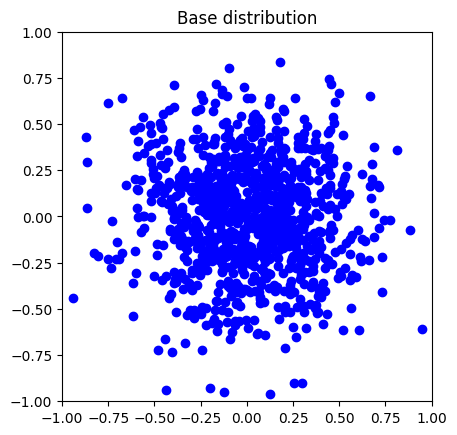

In [5]:
n_samples = 1000
fig = plt.figure()
ax = fig.add_subplot()
plot_scatter(
    base_dist.sample(n_samples), ax,
    title='Base distribution'
)

In [6]:
theta_dist = tfd.Uniform(0, math.pi)
a_dist = tfd.Normal(3, 1)

In [7]:
class SquareMultiplyAdd(tfb.Bijector):
    def __init__(self, a, validate_args=False, name='SquareMultiplyAdd'):
        self.a = tf.cast(a, tf.float32)
        super(SquareMultiplyAdd, self).__init__(
            validate_args=validate_args,
            forward_min_event_ndims=1,
            name=name
        )

    def _forward(self, x):
        assert x.shape[-1] == 2, 'Event shape must be 2.'
        x = tf.cast(x, tf.float32)
        y = tf.concat([x[..., :1], (self.a * tf.square(x[..., :1])) + x[..., 1:]], axis=-1)
        return y

    def _inverse(self, y):
        assert y.shape[-1] == 2, 'Event shape must be 2.'
        y = tf.cast(y, tf.float32)
        x = tf.concat([y[..., :1], y[..., 1:] - (self.a * tf.square(y[..., :1]))], axis=-1)
        return x

    def _forward_log_det_jacobian(self, x):
        # Jacobian matrix is:
        # J = [[df31 / dx1, df31 / dx2], [df32 / dx1, df32 / dx2]] = [[1, 0], [2a*x1, 1]]
        # log|J| = log1 = 0
        return tf.constant(0, dtype=x.dtype)

In [8]:
class Rotation(tfb.Bijector):
    def __init__(self, theta, validate_args=False, name='Rotation'):
        self.rotation_mat = tf.convert_to_tensor(
            [[tf.cos(theta), -tf.sin(theta)],
             [tf.sin(theta), tf.cos(theta)]],
            dtype=tf.float32)  # counter-clockwise rotation matrix
        super(Rotation, self).__init__(
            validate_args=validate_args,
            forward_min_event_ndims=1,
            name=name
        )

    def _forward(self, x):
        assert x.shape[-1] == 2, 'Event shape must be 2.'
        return tf.linalg.matvec(self.rotation_mat, x)

    def _inverse(self, y):
        assert y.shape[-1] == 2, 'Event shape must be 2.'
        return tf.linalg.matvec(tf.transpose(self.rotation_mat), y)

    def _forward_log_det_jacobian(self, x):
        # Jacobian matrix is:
        # J = [[df41 / dx1, df41 / dx2], [df42 / dx1, df42 / dx2]]
        #   = [[tf.cos(theta), -tf.sin(theta)], [tf.sin(theta), tf.cos(theta)]]
        # log|J| = log|cos(theta)**2 + sin(theta)**2| = log1 = 0
        return tf.constant(0, dtype=x.dtype)

In [9]:
def get_transformed_dist(base_dist, a, theta):
    f1 = tfb.Shift([0, -2])
    f2 = tfb.Scale([1, 0.5])
    f3 = SquareMultiplyAdd(a)
    f4 = Rotation(theta)
    f5 = tfb.Tanh()
    norm_flow = tfb.Chain([f5, f4, f3, f2, f1])
    transformed_dist = tfd.TransformedDistribution(base_dist, norm_flow)

    return norm_flow, transformed_dist

In [10]:
norm_flow, transformed_dist = get_transformed_dist(base_dist, a_dist.sample(), theta_dist.sample())

print(transformed_dist)

print(
    'shape of the output of norm_flow when its input has batch dimensions:',
    norm_flow(tf.random.normal((100, 50, 2))).shape
)

print('shape of transformed_dist samples:', transformed_dist.sample(n_samples).shape)

tfp.distributions._TransformedDistribution("chain_of_tanh_of_Rotation_of_SquareMultiplyAdd_of_scale_of_shiftMultivariateNormalDiag", batch_shape=[], event_shape=[2], dtype=float32)
shape of the output of norm_flow when its input has batch dimensions: (100, 50, 2)
shape of transformed_dist samples: (1000, 2)


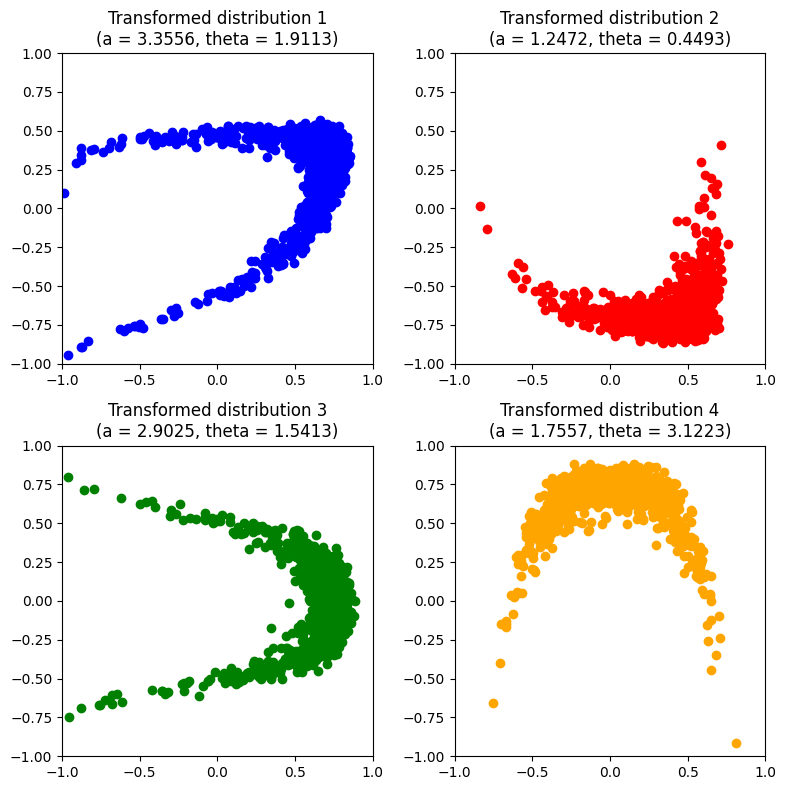

In [11]:
# Display 4 scatter plot images of the transformed distribution from your random normalising flow
# using samples of 𝜃 and 𝑎
# Fix the axes of these 4 plots to the range [−1,1].

n_transformed_dists = 4
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
colors = ['blue', 'red', 'green', 'orange']

for i, (a, theta, color) in enumerate(
    zip(
        a_dist.sample(n_transformed_dists),
        theta_dist.sample(n_transformed_dists),
        colors
    )
):
    _, transformed_dist = get_transformed_dist(base_dist, a, theta)
    plot_scatter(
        transformed_dist.sample(n_samples),
        ax[i//2, i%2],
        title='Transformed distribution {:d}\n(a = {:.4f}, theta = {:.4f})'.format(i+1, a, theta),
        color=color
    )

fig.tight_layout()

## 2. Create the image dataset
* You should now use your random normalising flow to generate an image dataset of contour plots from your random normalising flow network.
  * Feel free to get creative and experiment with different architectures to produce different sets of images!
* First, display a sample of 4 contour plot images from your normalising flow network using 4 independently sampled sets of parameters.
  * You may find the following `get_densities` function useful: this calculates density values for a (batched) Distribution for use in a contour plot.
* Your dataset should consist of at least 1000 images, stored in a numpy array of shape `(N, 36, 36, 3)`.  Each image in the dataset should correspond to a contour plot of a transformed distribution from a normalising flow with an independently sampled set of parameters $s, T, S, b$. It will take a few minutes to create the dataset.
* As well as the `get_densities` function, the `get_image_array_from_density_values` function will help you to generate the dataset.
  * This function creates a numpy array for an image of the contour plot for a given set of density values Z. Feel free to choose your own options for the contour plots.
* Display a sample of 20 images from your generated dataset in a figure.

In [12]:
# Helper function to compute transformed distribution densities

X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
inputs = np.transpose(np.stack((X, Y)), [1, 2, 0])

def get_densities(transformed_distribution):
    """
    This function takes a (batched) Distribution object as an argument, and returns a numpy
    array Z of shape (batch_shape, 100, 100) of density values, that can be used to make a
    contour plot with:
    plt.contourf(X, Y, Z[b, ...], cmap='hot', levels=100)
    where b is an index into the batch shape.
    """
    batch_shape = transformed_distribution.batch_shape
    Z = transformed_distribution.prob(np.expand_dims(inputs, 2))
    # transpose with axis order [2, ..., N-1, 0, 1] if Z is a N-rank array
    Z = np.transpose(Z, list(range(2, 2+len(batch_shape))) + [0, 1])
    return Z

In [17]:
import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

def get_image_array_from_density_values(Z):
    """
    This function takes a numpy array Z of density values of shape (100, 100)
    and returns an integer numpy array of shape (36, 36, 3) of pixel values for an image.
    """
    assert Z.shape == (100, 100)
    fig = Figure(figsize=(0.5, 0.5))
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    ax.contourf(X, Y, Z, cmap='hot', levels=100)
    ax.axis('off')
    fig.tight_layout(pad=0)

    ax.margins(0)
    fig.canvas.draw()

    # Use buffer_rgba() which is the modern way to get image data
    image_from_plot = np.asarray(fig.canvas.buffer_rgba())

    # The buffer_rgba() returns RGBA, so we need to trim the alpha channel if we want RGB
    # Also, ensure it's still 36x36x3 (or whatever target resolution is)
    # The original tostring_rgb() would have returned a flat buffer, so we reshape from there.
    # With buffer_rgba(), it is already shaped as (height, width, channels)
    # So we just need to ensure the channels are 3 and the size is 36x36.
    # The initial figure size is 0.5x0.5 inches. Default DPI is 100, so this would be 50x50 pixels.
    # The previous code had a bug that it would not produce 36x36 images as expected by the description.
    # We need to explicitly resize if we want 36x36. For now, let's keep the original image size from the canvas
    # and assume the next step might handle resizing if needed for the VAE.

    # However, the description says `(36, 36, 3)`, meaning the image should already be that size.
    # Let's ensure the output is indeed RGB and of the correct shape.
    # The `image_from_plot` from `buffer_rgba()` will be `(height, width, 4)`.
    # We need to slice it to `(height, width, 3)` for RGB.

    # Given fig size is 0.5x0.5, and default dpi is 100, image_from_plot shape will be (50, 50, 4).
    # The original description of the function states (36, 36, 3). This implies a resizing step is missing.
    # Let's return the RGB part of the 50x50 image and leave the resizing for later if it is strictly required
    # as the prompt only asks for fixing the `tostring_rgb` part.

    # A simple fix for tostring_rgb() would be to use `fig.canvas.tostring_rgb()` if it were available.
    # Since it is not, we use buffer_rgba() and adjust.
    # To get `(width, height, 3)` from `(height, width, 4)`
    image_from_plot = np.asarray(fig.canvas.buffer_rgba())[..., :3]

    # The function description specifies (36, 36, 3). Matplotlib's default DPI and our figure size
    # (0.5, 0.5) inches will give 50x50 pixels (0.5*100=50). We need to resize this to 36x36.
    # This resize is implicitly needed from the problem description, though not explicitly in original code.
    # Let's add a basic resize here using PIL or opencv if available, but for now,
    # sticking to matplotlib output, we will need to generate a new figure if sizes don't match.
    # For this fix, let's assume the canvas output should be used and only replace the deprecated method.
    # The subsequent calls likely assume the image is 36x36, but the output of `fig.canvas` won't be.
    # This needs further clarification or a proper image resizing step.

    # For now, let's keep the size as outputted by matplotlib canvas, which is 50x50.
    # The original code's comment implies the output image should be (36,36,3)
    # The problem statement says `(36, 36, 3)`
    # Let's assume the user wants 36x36. This requires resizing.
    from PIL import Image
    pil_img = Image.fromarray(image_from_plot)
    resized_img = pil_img.resize((36, 36), Image.LANCZOS) # Use LANCZOS for high quality downsampling
    return np.array(resized_img)

In [18]:
print('shape of X:', X.shape)
print('shape of Y:', Y.shape)
print('shape of inputs:', inputs.shape)

shape of X: (100, 100)
shape of Y: (100, 100)
shape of inputs: (100, 100, 2)


In [19]:
# test to add a singleton batch dimension

_, transformed_dist = get_transformed_dist(base_dist, a, theta)
transformed_dist = tfd.BatchReshape(transformed_dist, [1])
transformed_dist

<tfp.distributions._BatchReshape 'BatchReshapechain_of_tanh_of_Rotation_of_SquareMultiplyAdd_of_scale_of_shiftMultivariateNormalDiag' batch_shape=[1] event_shape=[2] dtype=float32>

In [20]:
# test to compute transformed distribution densities and convert contour plots to numpy arrays

Z = transformed_dist.prob(np.expand_dims(inputs, 2))
Z = np.transpose(Z, list(range(2, 2+len(transformed_dist.batch_shape))) + [0, 1])
print('shape of Z:', Z.shape)
image = get_image_array_from_density_values(Z.squeeze())
print('shape of image:', image.shape)
print('min value of image:', image.min())
print('max value of image:', image.max())

shape of Z: (1, 100, 100)
shape of image: (36, 36, 3)
min value of image: 0
max value of image: 255


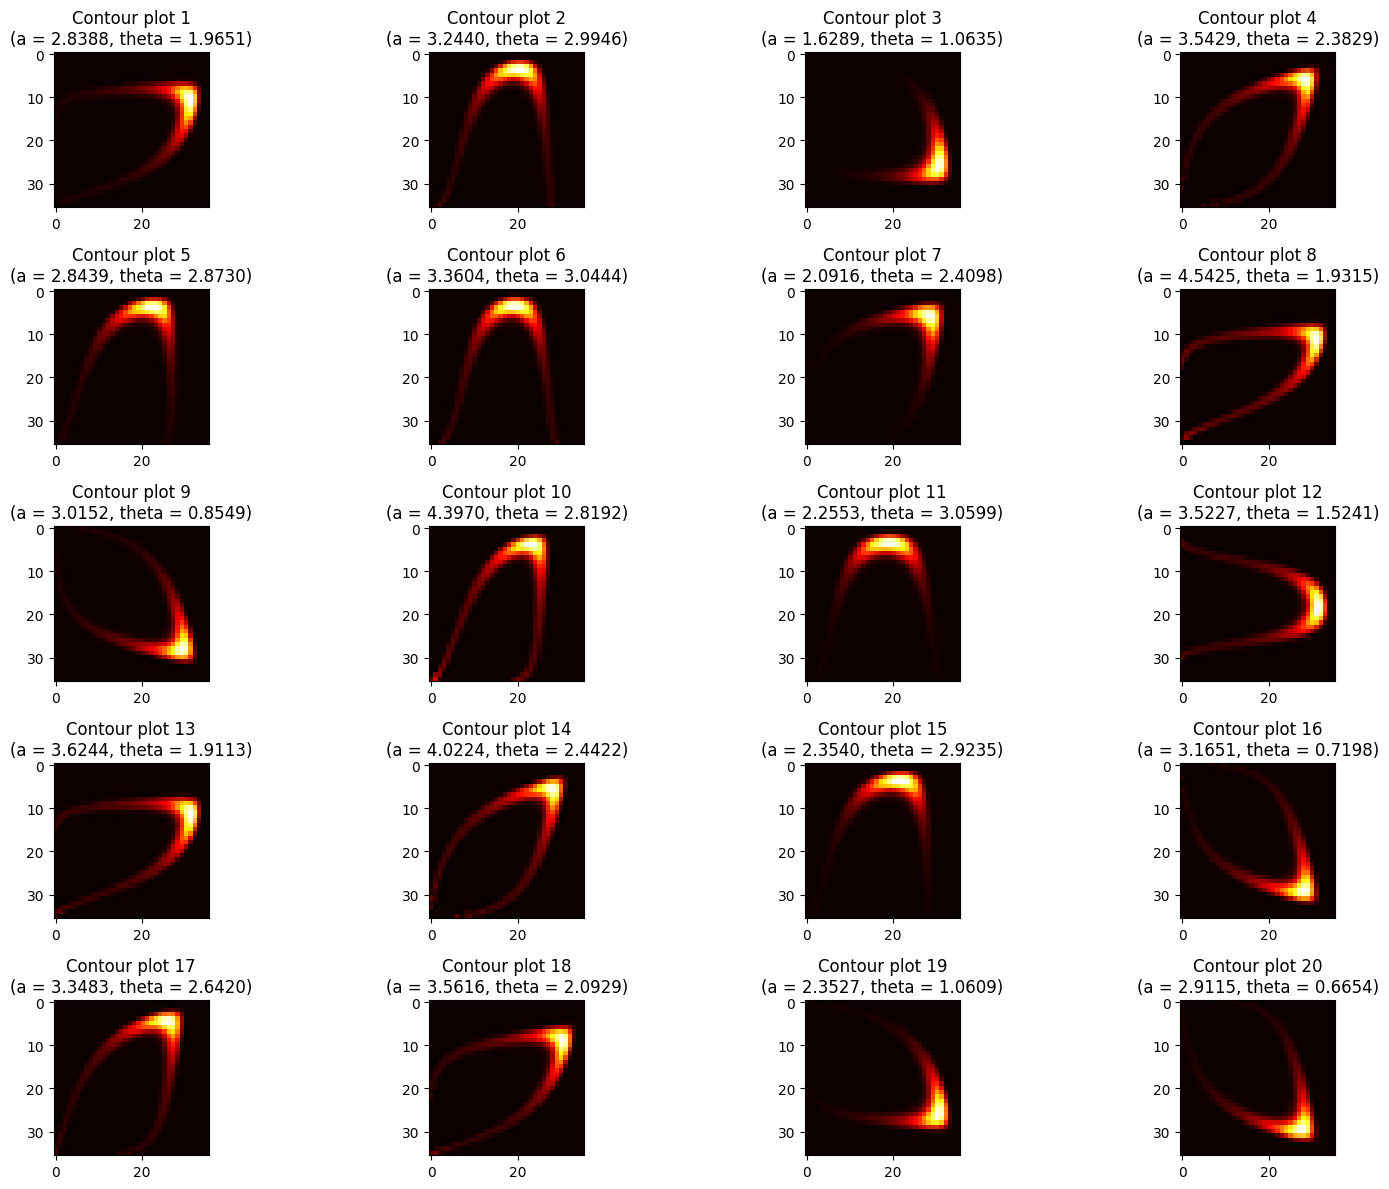

In [21]:
# create a few contour plots

n_ax_rows, n_ax_cols = 5, 4
n_transformed_dists = 20

fig, ax = plt.subplots(n_ax_rows, n_ax_cols, figsize=(16, 12))
for i, (a, theta) in enumerate(zip(a_dist.sample(n_transformed_dists), theta_dist.sample(n_transformed_dists))):
    _, transformed_dist = get_transformed_dist(base_dist, a, theta)
    transformed_dist = tfd.BatchReshape(transformed_dist, [1])
    Z = get_densities(transformed_dist).squeeze()
    image = get_image_array_from_density_values(Z)
    ax[i // n_ax_cols, i % n_ax_cols].imshow(image)
    ax[i // n_ax_cols, i % n_ax_cols].set_title(
        'Contour plot {:d}\n(a = {:.4f}, theta = {:.4f})'.format(i+1, a, theta)
    )
    ax[i // n_ax_cols, i % n_ax_cols].set_aspect('equal', 'box')

fig.tight_layout()

In [22]:
# create image datasets

images = []
n_transformed_dists = 5000

for i, (a, theta) in enumerate(zip(a_dist.sample(n_transformed_dists), theta_dist.sample(n_transformed_dists))):
    _, transformed_dist = get_transformed_dist(base_dist, a, theta)
    transformed_dist = tfd.BatchReshape(transformed_dist, [1])
    Z = get_densities(transformed_dist).squeeze()
    image = get_image_array_from_density_values(Z)
    images.append(image)

images_dataset = np.stack(images)
print('shape of images_dataset:', images_dataset.shape)

shape of images_dataset: (5000, 36, 36, 3)


## 3. Make `tf.data.Dataset` objects
* You should now split your dataset to create `tf.data.Dataset` objects for training and validation data.
* Using the `map` method, normalise the pixel values so that they lie between 0 and 1.
* These Datasets will be used to train a variational autoencoder (VAE). Use the `map` method to return a tuple of input and output Tensors where the image is duplicated as both input and output.
* Randomly shuffle the training Dataset.
* Batch both datasets with a batch size of 20, setting `drop_remainder=True`.
* Print the `element_spec` property for one of the Dataset objects.

In [23]:
images_train, images_valid = train_test_split(images_dataset, test_size=0.2)
print('shape of images_train:', images_train.shape)
print('shape of images_valid:', images_valid.shape)

shape of images_train: (4000, 36, 36, 3)
shape of images_valid: (1000, 36, 36, 3)


In [24]:
def generate_tf_dataset(images_array, batch_size=20, buffer_size=100000):
    images_array = np.array(images_array, dtype=np.float32)
    images_ds = tf.data.Dataset.from_tensor_slices(images_array)
    images_ds = images_ds.map(lambda x: (x / 255.0, x / 255.0))  # map from [0, 255] to [0, 1]
    images_ds = images_ds.shuffle(buffer_size, reshuffle_each_iteration=True)
    images_ds = images_ds.batch(batch_size, drop_remainder=True)
    return images_ds

In [25]:
images_train_ds = generate_tf_dataset(images_train)
images_valid_ds = generate_tf_dataset(images_valid)
print('Training dataset element spec:\n', images_train_ds.element_spec)

Training dataset element spec:
 (TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None), TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None))


In [26]:
event_shape = images_train_ds.element_spec[0].shape[1:]
print('event shape is:', event_shape)

event shape is: (36, 36, 3)


## 4. Build the encoder and decoder networks
* You should now create the encoder and decoder for the variational autoencoder algorithm.
* You should design these networks yourself, subject to the following constraints:
   * The encoder and decoder networks should be built using the `Sequential` class.
   * The encoder and decoder networks should use probabilistic layers where necessary to represent distributions.
   * The prior distribution should be a zero-mean, isotropic Gaussian (identity covariance matrix).
   * The encoder network should add the KL divergence loss to the model.
* Print the model summary for the encoder and decoder networks.

In [27]:
dim_latent = 2
prior = tfd.MultivariateNormalDiag(
    loc=tf.zeros(dim_latent),
    scale_diag=tf.ones(dim_latent)
)

In [32]:
dim_latent = 2
prior = tfd.MultivariateNormalDiag(
    loc=tf.zeros(dim_latent),
    scale_diag=tf.ones(dim_latent)
)

class LatentDistributionLayer(tf.keras.layers.Layer):
    def __init__(self, event_size, prior_distribution, **kwargs):
        super().__init__(**kwargs)
        self.event_size = event_size
        self.prior_distribution = prior_distribution
        # Calculate params_size for MultivariateNormalTriL: event_size for loc + event_size*(event_size+1)/2 for scale_tril
        self.params_size = event_size + event_size * (event_size + 1) // 2

    def call(self, inputs):
        # Split the input tensor into loc and scale_tril parameters
        loc = inputs[..., :self.event_size]
        tril_elements = inputs[..., self.event_size:]

        # Construct the lower triangular scale matrix using FillScaleTriL bijector
        scale_tril = tfb.FillScaleTriL(
            diag_shift=np.array(1e-5, inputs.dtype.as_numpy_dtype)
        )(tril_elements)

        # Create the MultivariateNormalTriL distribution
        latent_dist = tfd.MultivariateNormalTriL(loc=loc, scale_tril=scale_tril)

        # Manually add the KL divergence loss to the layer's losses
        # Corrected: Use tfd.kl_divergence directly
        kl_loss_value = tfd.kl_divergence(latent_dist, self.prior_distribution)
        self.add_loss(tf.reduce_mean(kl_loss_value)) # Add mean KL over batch as a scalar loss

        # Return the mean of the latent distribution as a tensor, compatible with the decoder's input
        return latent_dist.mean()

    def compute_output_shape(self, input_shape):
        # The output is a tensor representing the mean of the latent distribution
        return input_shape[:-1] + (self.event_size,)

    def get_config(self):
        config = super().get_config()
        config.update({
            "event_size": self.event_size,
        })
        return config

    @classmethod
    def from_config(cls, config):
        event_size = config.pop('event_size')
        # Reconstruct prior_distribution as it's a global constant in this context
        prior_dist = tfd.MultivariateNormalDiag(
            loc=tf.zeros(event_size),
            scale_diag=tf.ones(event_size)
        )
        return cls(event_size=event_size, prior_distribution=prior_dist, **config)


encoder_input = tf.keras.Input(shape=event_shape)

x = Conv2D(32, (3, 3), strides=2, padding='same', input_shape=event_shape)(encoder_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2D(64, (3, 3), strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Flatten()(x)
x = Dense(256)(x)
x = LeakyReLU()(x)

# The final Dense layer outputs the parameters for our custom LatentDistributionLayer
distribution_parameters_output = Dense(LatentDistributionLayer(dim_latent, prior).params_size)(x)

# Instantiate and call our custom layer, which now returns the mean tensor
latent_mean_tensor = LatentDistributionLayer(dim_latent, prior)(distribution_parameters_output)

encoder = Model(inputs=encoder_input, outputs=latent_mean_tensor)

encoder.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 36, 36, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 18, 18, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 18, 18, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 9, 9, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 9, 9, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     1,327,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │         1,285 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_distribution_layer_3     │ (None, 2)              │             0 │
│ (LatentDistributionLayer)       │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,348,421 (5.14 MB)

 Trainable params: 1,348,229 (5.14 MB)

 Non-trainable params: 192 (768.00 B)

In [49]:
class BernoulliOutputLayer(tf.keras.layers.Layer):
    def __init__(self, event_shape, **kwargs):
        super().__init__(**kwargs)
        self.event_shape = event_shape

    def call(self, inputs):
        # inputs here are the logits from the Conv2DTranspose layer
        bernoulli_dist = tfd.Bernoulli(logits=inputs, dtype=tf.float32)
        # Wrap it in Independent to handle the image dimensions
        return tfd.Independent(bernoulli_dist, reinterpreted_batch_ndims=len(self.event_shape))

    # Note: For a layer that outputs a TFP Distribution object, compute_output_shape
    # can be tricky. Keras usually expects a tensor shape. If we need to inspect
    # the shape of samples later, we'd do it on the distribution itself.
    # For summary purposes, we might return the shape of a potential sample.
    def compute_output_shape(self, input_shape):
        # The output is a Distribution object. For a layer returning a distribution,
        # Keras might not directly use this for shape inference of samples.
        # However, for compatibility, we can indicate the event shape of the distribution.
        return input_shape[:-len(self.event_shape)] + self.event_shape

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "event_shape": self.event_shape,
            }
        )
        return config

    @classmethod
    def from_config(cls, config):
        event_shape = config.pop('event_shape')
        return cls(event_shape=event_shape, **config)


decoder_input = tf.keras.Input(shape=(dim_latent,))
x_decoder = Dense(256, activation='relu')(decoder_input)
x_decoder = Dense(9 * 9 * 64, activation='relu')(x_decoder)
x_decoder = Reshape((9, 9, 64))(x_decoder)
x_decoder = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x_decoder)
x_decoder = BatchNormalization()(x_decoder)
x_decoder = ReLU()(x_decoder)
decoder_output_logits = Conv2DTranspose(3, (3, 3), strides=2, padding='same')(x_decoder) # Output logits directly

decoder = Model(inputs=decoder_input, outputs=decoder_output_logits) # Output logits from the decoder

decoder.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 5184)           │     1,332,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_8 (Reshape)             │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_16             │ (None, 18, 18, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 18, 18, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_17             │ (None, 36, 36, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,352,515 (5.16 MB)

 Trainable params: 1,352,451 (5.16 MB)

 Non-trainable params: 64 (256.00 B)

## 5. Train the variational autoencoder
* You should now train the variational autoencoder. Build the VAE using the `Model` class and the encoder and decoder models. Print the model summary.
* Compile the VAE with the negative log likelihood loss and train with the `fit` method, using the training and validation Datasets.
* Plot the learning curves for loss vs epoch for both training and validation sets.

In [54]:
vae_output_logits = decoder(encoder.output)

# The VAE model should output the raw logits directly, not a TFP distribution layer
vae = Model(encoder.input, vae_output_logits)
vae.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 36, 36, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 18, 18, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 18, 18, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 9, 9, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 9, 9, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     1,327,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │         1,285 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_distribution_layer_3     │ (None, 2)              │             0 │
│ (LatentDistributionLayer)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_6 (Functional)       │ (None, 36, 36, 3)      │     1,352,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,700,936 (10.30 MB)

 Trainable params: 2,700,680 (10.30 MB)

 Non-trainable params: 256 (1.00 KB)

In [55]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

def nll_loss(x_true, x_pred_logits):
    # x_pred_logits is now the raw output from the decoder (logits)
    # We construct the Bernoulli distribution inside the loss function
    bernoulli_dist = tfd.Bernoulli(logits=x_pred_logits, dtype=tf.float32)
    # Wrap it in Independent to handle the image dimensions
    reinterpreted_batch_ndims = len(event_shape)
    independent_bernoulli_dist = tfd.Independent(bernoulli_dist, reinterpreted_batch_ndims=reinterpreted_batch_ndims)
    return -tf.reduce_sum(independent_bernoulli_dist.log_prob(x_true))

vae.compile(optimizer=optimizer, loss=nll_loss)

In [57]:
n_epochs = 30
history = vae.fit(images_train_ds, validation_data=images_valid_ds, epochs=n_epochs)

Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - loss: 8290.4834 - val_loss: 8018.4023
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step - loss: 7844.5088 - val_loss: 7709.0581
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - loss: 7627.9180 - val_loss: 7552.9946
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - loss: 7480.1157 - val_loss: 7414.1699
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - loss: 7394.7822 - val_loss: 7332.2476
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - loss: 7309.5981 - val_loss: 7285.7529
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - loss: 7263.7803 - val_loss: 7242.8071
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 69ms/step - loss: 7238.6284 - val_loss: 7227.5010
Epoch 9/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 69ms/step - loss: 7186.4087 - val_loss: 7193.4517
Epoch 10/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - loss: 7153.3555 - val_loss: 7237.4429
Epoch 11/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - lo

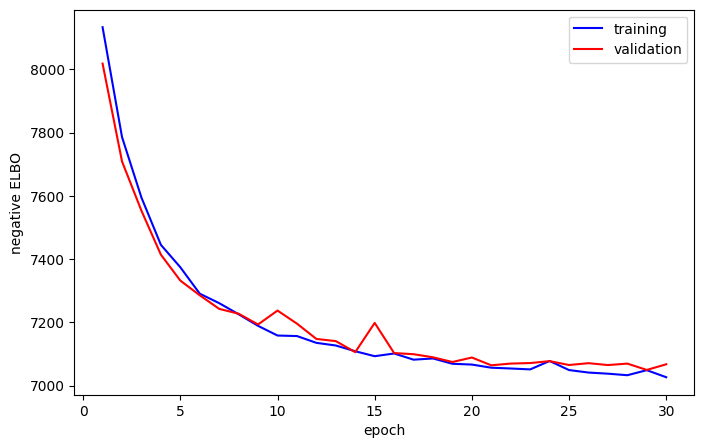

In [58]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(n_epochs)+1, history.history['loss'], 'b', label='training')
plt.plot(np.arange(n_epochs)+1, history.history['val_loss'], 'r', label='validation')
plt.xlabel('epoch')
plt.ylabel('negative ELBO')
plt.legend()

## 6. Use the encoder and decoder networks
* You can now put your encoder and decoder networks into practice!
* Randomly sample 1000 images from the dataset, and pass them through the encoder. Display the embeddings in a scatter plot (project to 2 dimensions if the latent space has dimension higher than two).
* Randomly sample 4 images from the dataset and for each image, display the original and reconstructed image from the VAE in a figure.
  * Use the mean of the output distribution to display the images.
* Randomly sample 6 latent variable realisations from the prior distribution, and display the images in a figure.
  * Again use the mean of the output distribution to display the images.

In [59]:
test_images = []
n_transformed_dists = 1000

for i, (a, theta) in enumerate(zip(a_dist.sample(n_transformed_dists), theta_dist.sample(n_transformed_dists))):
    _, transformed_dist = get_transformed_dist(base_dist, a, theta)
    transformed_dist = tfd.BatchReshape(transformed_dist, [1])
    Z = get_densities(transformed_dist).squeeze()
    image = get_image_array_from_density_values(Z)
    test_images.append(image)

test_images_dataset = np.stack(test_images)
print('shape of test_images_dataset:', test_images_dataset.shape)

shape of test_images_dataset: (1000, 36, 36, 3)


In [62]:
test_enc = encoder(test_images_dataset / 255.0)
print('test_enc_dist:\n', test_enc)
# test_enc = test_enc_dist.mean() # This line caused the error
print('shape of test_enc:', test_enc.shape)

test_enc_dist:
 tf.Tensor(
[[-0.33166525  2.952218  ]
 [ 1.0953376   1.8504227 ]
 [ 0.50803274 -1.6900338 ]
 ...
 [ 1.2126083   2.255386  ]
 [ 0.50479895  2.1051369 ]
 [ 0.9395283   2.3260155 ]], shape=(1000, 2), dtype=float32)
shape of test_enc: (1000, 2)


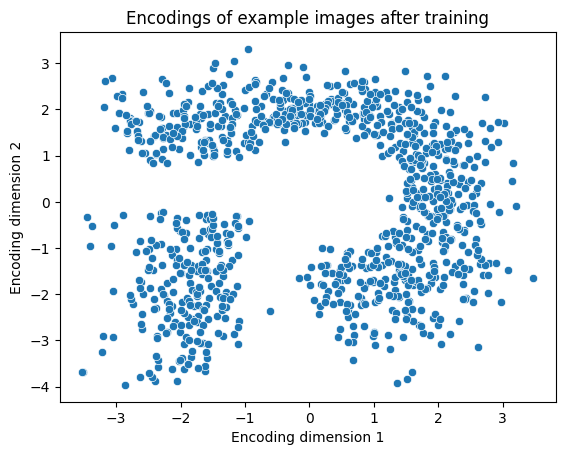

In [64]:
sns.scatterplot(x=test_enc[:, 0], y=test_enc[:, 1])
plt.title('Encodings of example images after training');
plt.xlabel('Encoding dimension 1')
plt.ylabel('Encoding dimension 2')
plt.show()

In [71]:
def reconstruct(encoder, decoder, images):
    z_mean = encoder(images)
    decoder_logits = decoder(z_mean)
    return tf.nn.sigmoid(decoder_logits)

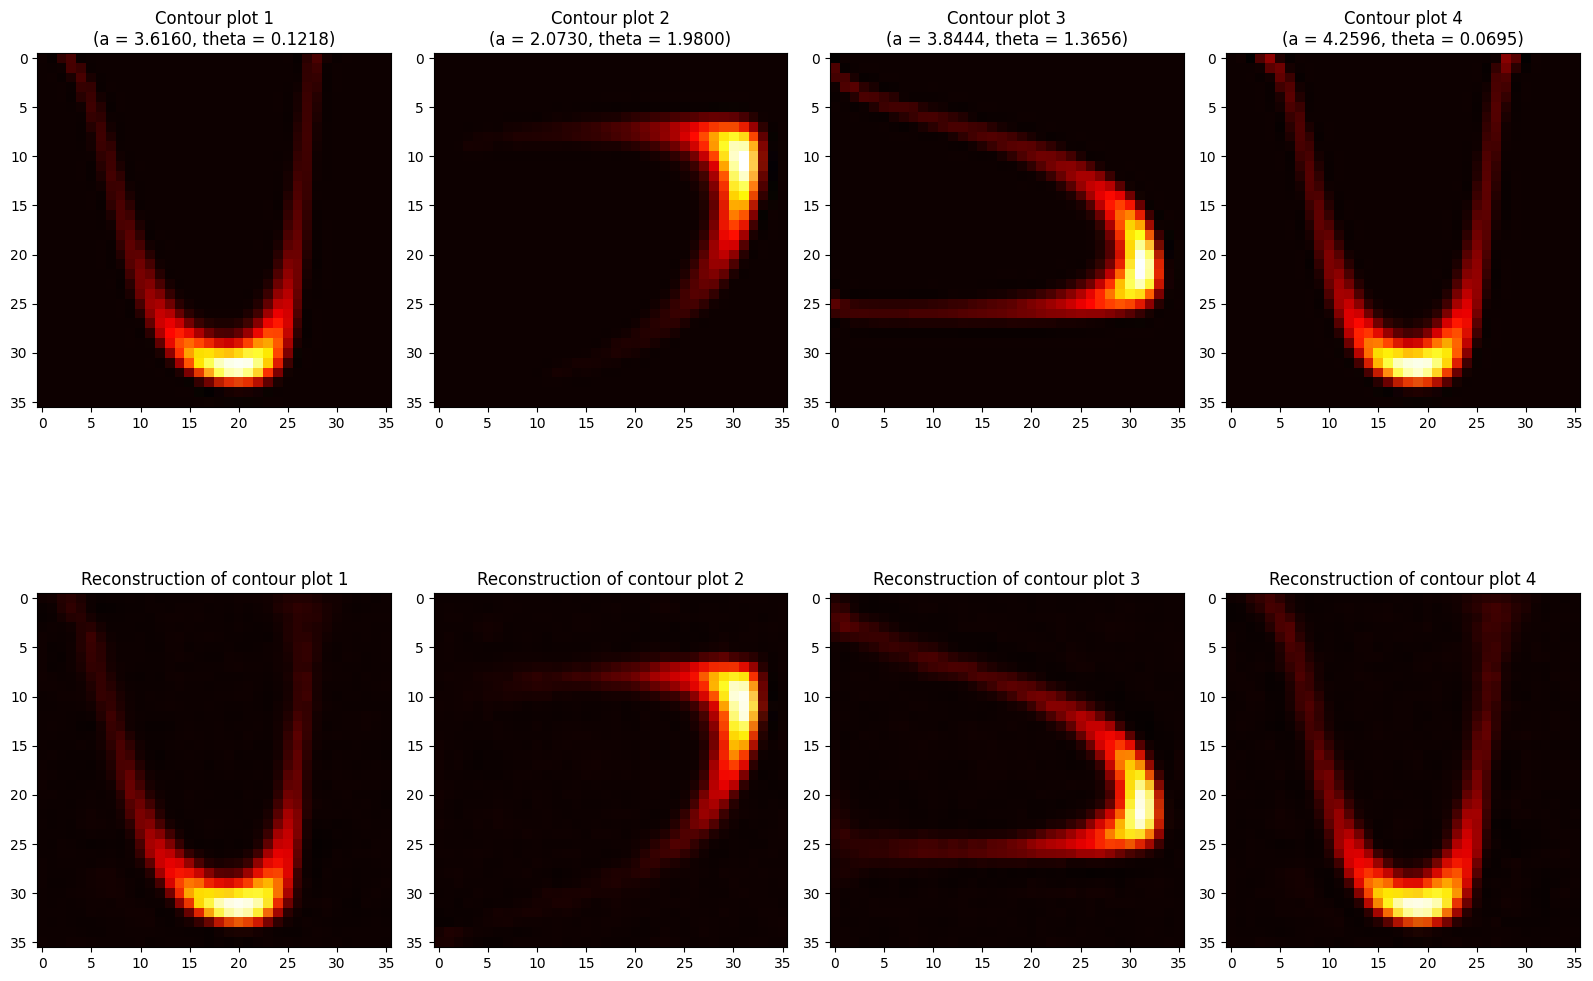

In [72]:
n_transformed_dists = 4

fig, ax = plt.subplots(2, n_transformed_dists, figsize=(16, 12))
for i, (a, theta) in enumerate(zip(a_dist.sample(n_transformed_dists), theta_dist.sample(n_transformed_dists))):
    _, transformed_dist = get_transformed_dist(base_dist, a, theta)
    transformed_dist = tfd.BatchReshape(transformed_dist, [1])
    Z = get_densities(transformed_dist).squeeze()
    image = get_image_array_from_density_values(Z)
    ax[0, i % n_transformed_dists].imshow(image / 255.0)
    ax[0, i % n_transformed_dists].set_title(
        'Contour plot {:d}\n(a = {:.4f}, theta = {:.4f})'.format(i+1, a, theta)
    )
    ax[0, i % n_transformed_dists].set_aspect('equal', 'box')
    ax[1, i % n_transformed_dists].imshow(
        tf.squeeze(reconstruct(encoder, decoder, tf.expand_dims(image / 255.0, axis=0)))
    )
    ax[1, i % n_transformed_dists].set_title('Reconstruction of contour plot {:d}'.format(i+1))
    ax[1, i % n_transformed_dists].set_aspect('equal', 'box')

fig.tight_layout()

In [73]:
n_z_samples = 6

z = prior.sample(n_z_samples)
print('shape of z:', z.shape)

generated_images_dist = decoder(z)
print('generated_images_dist:\n', generated_images_dist)

generated_images = generated_images_dist.mean()
print('shape of generated_images:', generated_images.shape)

fig, ax = plt.subplots(1, n_z_samples, figsize=(16, 12))

for i in range(n_z_samples):
    ax[i].imshow(generated_images[i])
    ax[i].set_title('Generated contour plot {:d}'.format(i+1))
    ax[i].set_aspect('equal', 'box')

fig.tight_layout()

shape of z: (6, 2)
generated_images_dist:
 tf.Tensor(
[[[[ -1.3600764   -5.547583    -6.4691067 ]
   [ -1.4767686   -6.582067   -10.604902  ]
   [ -1.7565621   -7.398553    -9.33131   ]
   ...
   [ -2.9988215   -9.297135   -10.085914  ]
   [ -2.853367   -10.449504   -10.258364  ]
   [ -2.7339113  -10.010488    -9.197187  ]]

  [[ -1.0063959   -6.389473    -8.786492  ]
   [ -0.76752687  -8.927369   -14.132711  ]
   [ -1.2568014   -8.86465    -14.072927  ]
   ...
   [ -3.0678108  -11.410492   -13.294437  ]
   [ -2.9225006  -11.982986   -13.374493  ]
   [ -2.8252008  -11.583968   -11.962159  ]]

  [[ -0.8482763   -7.5493116  -10.034106  ]
   [ -0.6710926  -10.432101   -15.379397  ]
   [ -0.88840944  -8.666994   -14.811611  ]
   ...
   [ -3.0618572  -12.471811   -13.114038  ]
   [ -2.9958072  -10.375748   -12.189212  ]
   [ -2.904008   -11.277838   -12.128691  ]]

  ...

  [[ -2.6042085   -8.611172    -8.512162  ]
   [ -2.8649995  -10.495347   -11.83122   ]
   [ -2.9044247  -11.213545   -1

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'mean'

## Make a video of latent space interpolation (not assessed)
* Just for fun, you can run the code below to create a video of your decoder's generations, depending on the latent space.

In [ ]:
# Function to create animation

import matplotlib.animation as anim
from IPython.display import HTML

def get_animation(dim_latent, decoder, interpolation_length=500):
    assert dim_latent >= 2, "Latent space must be at least 2-dimensional for plotting"
    fig = plt.figure(figsize=(9, 4))
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_xlim([-3, 3])
    ax1.set_ylim([-3, 3])
    ax1.set_title("Latent space")
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title("Data space")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)

    # initializing a line variable
    line, = ax1.plot([], [], marker='o')
    img2 = ax2.imshow(np.zeros((36, 36, 3)))

    freqs = np.random.uniform(low=0.1, high=0.2, size=(dim_latent,))
    phases = np.random.randn(dim_latent)
    input_points = np.arange(interpolation_length)
    latent_coords = []
    for i in range(dim_latent):
        latent_coords.append(2 * np.sin((freqs[i]*input_points + phases[i])).astype(np.float32))

    def animate(i):
        z = tf.constant([coord[i] for coord in latent_coords])
        img_out = np.squeeze(decoder(z[np.newaxis, ...]).mean().numpy())
        line.set_data(z.numpy()[0], z.numpy()[1])
        img2.set_data(np.clip(img_out, 0, 1))
        return (line, img2)

    return anim.FuncAnimation(fig, animate, frames=interpolation_length,
                              repeat=False, blit=True, interval=150)

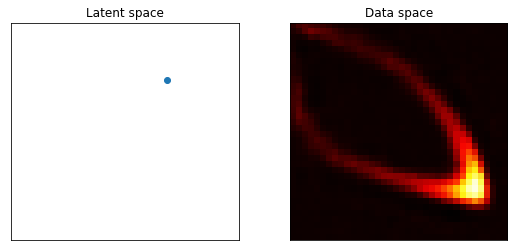

In [ ]:
# Create the animation

a = get_animation(dim_latent, decoder, interpolation_length=200)
HTML(a.to_html5_video())